In [191]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
import numpy as np
import matplotlib.pyplot as plt

In [198]:
import sys
sys.path.append("/Users/santorum/Desktop/scikit-rmt/")

from skrmt.ensemble import WishartEnsemble
from skrmt.ensemble.spectral_law import MarchenkoPasturDistribution
from skrmt.ensemble.utils import plot_spectral_hist_and_law, get_bins_centers_and_contour

In [4]:
def plot_slices(slices, titles=None, cmap="gray", origin="lower"):
    """Function to display a row of image slices."""
    n_slices = len(slices)

    if titles is None:
        titles = [f"Slice {i+1}" for i in range(n_slices)]

    # Old: fig, axes = plt.subplots(1, n_slices, figsize=(3 * n_slices, 2 * n_slices))
    fig, axes = plt.subplots(1, n_slices, figsize=(3.5 * n_slices, 3.8))

    if len(slices) > 1:
        for i, slice_array in enumerate(slices):
            axes[i].imshow(slice_array, cmap=cmap, origin=origin, aspect="auto")
            axes[i].set_title(titles[i])
    else:
        axes.imshow(slices[0], cmap=cmap, origin=origin)
        axes.set_title(titles[0])

In [55]:
tumor_slice = np.load("sim_data/sample_tumor_img.npy")
tumor_slice.shape

(184, 132)

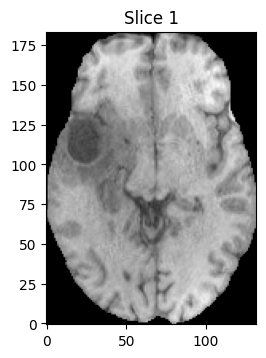

In [56]:
plot_slices([tumor_slice])

In [57]:
tumor_slice.min(), tumor_slice.max()

(0.0, 255.0)

In [58]:
def generate_noisy_imgs(
    original_img: np.ndarray,
    n_snapshots: int,
    sigma: float,
    seed: int,
) -> np.ndarray:
    """Generate `n_snapshots` noisy images of the given original image.

    Args:
        original_img (np.ndarray): 2d numpy array representing the original image
            of size (n_rows, n_cols) = (height, width).
        n_snapshots (int): number of noisy images to generate.
        sigma (float): gaussian standard deviation to corrupt the original image.

    Returns:
        np.ndarray: numpy array of size (n_snapshots, height, width).
    """
    np.random.seed(seed)

    gaussian_noise_mtcs = [np.random.randn(*original_img.shape) for _ in range(n_snapshots)]
    snapshots = [
        tumor_slice + sigma * randn_mtx
        for randn_mtx in gaussian_noise_mtcs
    ]
    return np.stack(snapshots, axis=0)

In [59]:
sigma = 50
snapshots = generate_noisy_imgs(tumor_slice, n_snapshots=100, sigma=sigma, seed=1)

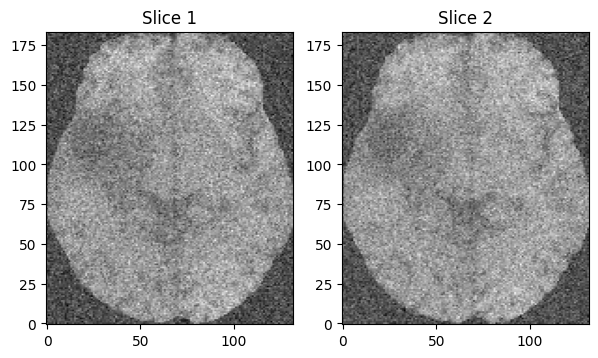

In [60]:
plot_slices([snapshots[0], snapshots[1]])

In [61]:
X = snapshots[:,100,:]
(M, N) = X.shape

# M := number of measurements
# N := number of pixels
M, N

(100, 132)

In [62]:
Sigma = (1/N) * np.matmul(X, X.T)

In [63]:
# this could be computed with MP object
lambda_ratio = M/N
lambda_max = sigma**2 * (1 + np.sqrt(lambda_ratio))**2

print(f"Ratio (M/N): {lambda_ratio}")
print(f"Lambda max: {lambda_max}")

Ratio (M/N): 0.7575757575757576
Lambda max: 8745.88079283184


In [52]:
U, S, Vh = np.linalg.svd((1/np.sqrt(N)) * X, full_matrices=False)

print(f"Matrix shape: {X.shape}")
print(f"U shape: {U.shape}")
print(f"S shape: {S.shape}")
print(f"Vh shape: {Vh.shape}")

Matrix shape: (100, 132)
U shape: (100, 100)
S shape: (100,)
Vh shape: (100, 132)


In [53]:
recover_X = np.sqrt(N) * np.dot(U * S, Vh)
np.allclose(X, recover_X)

True

In [66]:
eigvals = S**2
eigvals.shape

(100,)

In [67]:
denoised_eigvals = np.where(eigvals <= lambda_max, 0, eigvals)
denoised_eigvals.shape

(100,)

In [68]:
denoised_eigvals[denoised_eigvals != 0.0]

array([2088803.56510293])

In [69]:
denoised_S = np.sqrt(denoised_eigvals)
denoised_S.shape

(100,)

In [70]:
denoised_S[denoised_S != 0.0]

array([1445.26937458])

In [90]:
# faster solution to get denoised_S:
test_denoised_S = np.where(S <= np.sqrt(lambda_max), 0, S)
test_denoised_S[test_denoised_S != 0.0]

array([1445.26937458])

In [76]:
denoised_X = np.sqrt(N) * np.dot(U * denoised_S, Vh)

denoised_X.shape

(100, 132)

In [101]:
def denoise_row(X):
    # M := number of measurements
    # N := number of pixels
    (M, N) = X.shape

    lambda_ratio = M/N
    lambda_max = sigma**2 * (1 + np.sqrt(lambda_ratio))**2

    U, S, Vh = np.linalg.svd((1/np.sqrt(N)) * X, full_matrices=False)

    ### Theoretical solution
    # eigvals = S**2
    # denoised_eigvals = np.where(eigvals <= lambda_max, 0, eigvals)
    # denoised_S = np.sqrt(denoised_eigvals)
    ### Faster solution
    denoised_S = np.where(S <= np.sqrt(lambda_max), 0, S)

    denoised_X = np.sqrt(N) * np.dot(U * denoised_S, Vh)

    # return np.mean(denoised_X, axis=0)   # cheating
    return denoised_X[0]


def denoise_img(snapshots, sigma):
    n_snapshots, img_height, img_width = snapshots.shape
    print(f"{n_snapshots=}")
    print(f"{img_height=}")
    print(f"{img_width=}")

    denoised_img = []
    for i in range(img_height):
        rows = snapshots[:,i,:]
        denoised_row = denoise_row(X=rows)
        denoised_img.append(denoised_row)

    d = np.asarray(denoised_img)
    print(d.shape)
    
    plot_slices([np.asarray(denoised_img)]) 

    

n_snapshots=100
img_height=184
img_width=132
(184, 132)


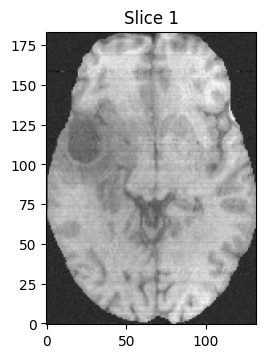

In [102]:
denoise_img(snapshots=snapshots, sigma=sigma)

### Using Marchenko-Pastur law explicitly

In [208]:
sigma = 50
snapshots = generate_noisy_imgs(tumor_slice, n_snapshots=100, sigma=sigma, seed=1)

In [209]:
X = snapshots[:,100,:]
(M, N) = X.shape

# M := number of measurements
# N := number of pixels
M, N

(100, 132)

In [210]:
U, S, Vh = np.linalg.svd((1/np.sqrt(N)) * X, full_matrices=False)

print(f"Matrix shape: {X.shape}")
print(f"U shape: {U.shape}")
print(f"S shape: {S.shape}")
print(f"Vh shape: {Vh.shape}")

Matrix shape: (100, 132)
U shape: (100, 100)
S shape: (100,)
Vh shape: (100, 132)


In [211]:
Sigma = (1/N) * np.matmul(X, X.T)

In [212]:
np.allclose(Sigma, np.dot(U * S**2, U.T))

True

In [213]:
wre = WishartEnsemble(beta=1, p=M, n=N, tridiagonal_form=False, sigma=sigma)

In [214]:
wre.matrix = Sigma

In [215]:
eigvals = wre.eigvals()

In [216]:
np.allclose(sorted(eigvals), sorted(S**2))

True

In [217]:
sorted(eigvals)[::-1][:10]

[2088803.56510293,
 8437.318508728118,
 8168.4220751715275,
 7499.34618056153,
 7391.94466996842,
 7270.727805464568,
 6788.752694468242,
 6754.679016821669,
 6657.985446754043,
 6441.243594588454]

In [218]:
sorted(S**2)[::-1][:10]

[2088803.5651029292,
 8437.318508728127,
 8168.422075171593,
 7499.346180561511,
 7391.944669968437,
 7270.727805464585,
 6788.752694468256,
 6754.6790168216685,
 6657.985446754052,
 6441.243594588463]

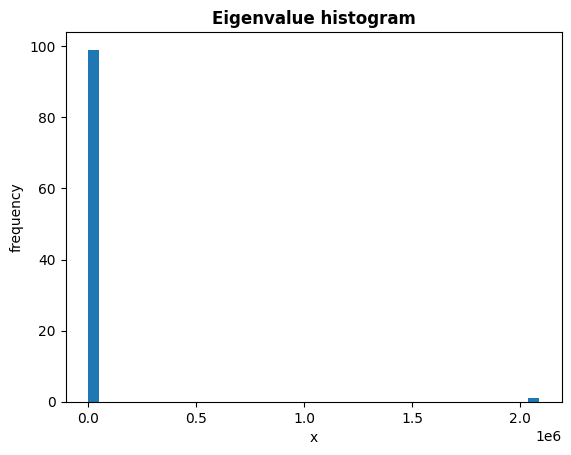

In [219]:
interval = (0.01, eigvals.max())
wre.plot_eigval_hist(bins=40, interval=interval, density=False, normalize=False)

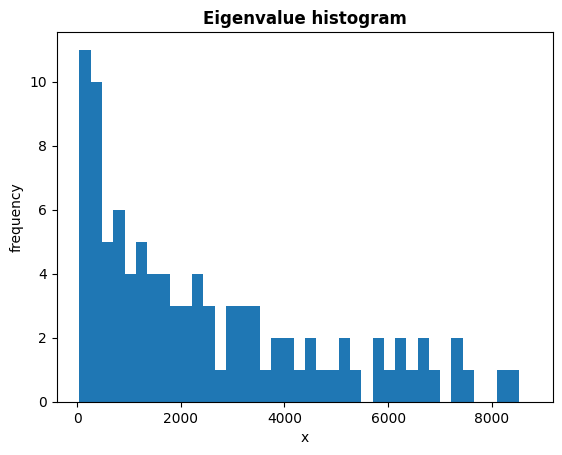

In [220]:
noise_interval = (wre.lambda_minus, wre.lambda_plus)
wre.plot_eigval_hist(bins=40, interval=noise_interval, density=False, normalize=False)

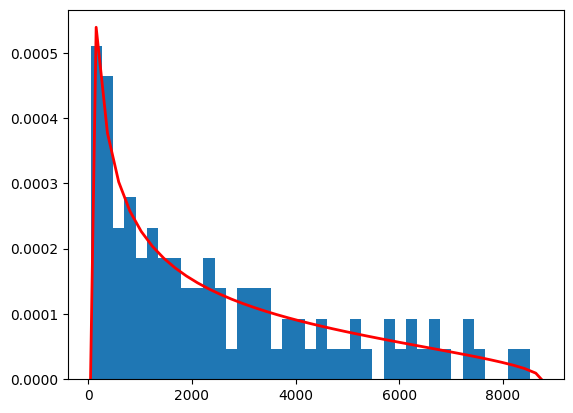

In [221]:
observed, bin_edges = wre.eigval_hist(
    bins=40, interval=noise_interval, density=True, normalize=False
)  # pylint: disable=protected-access
centers = np.asarray(get_bins_centers_and_contour(bin_edges))

mp_law = MarchenkoPasturDistribution(ratio=wre.ratio, sigma=sigma)
height = mp_law.pdf(centers)

width = bin_edges[1]-bin_edges[0]
plt.bar(bin_edges[:-1], observed, width=width, align='edge')

plt.plot(centers, height, color='red', linewidth=2)
plt.show()